# NHL Game Predictor
##### **Still in progress**
This is my attempt at a KNN NHL game predictor, using the KNN class I coded.
### Important Notes
* When I use the year, it refers to the year the season ends.
    * Like for example the 2024-2025 is marked as 2025.
* nhl-XX.csv is the score data for a given season.
    * Links to get this data is as follows:
      * [2022 Season](https://shanemcd.org/2021/09/23/2021-22-nhl-schedule-and-results-in-excel-xlsx-and-csv-formats/)
      * [2023 Season](https://shanemcd.org/2022/07/12/2022-23-nhl-schedule-and-results-in-excel-xlsx-and-csv-formats/)
      * [2024 Season](https://shanemcd.org/2023/08/23/2023-24-nhl-schedule-and-results-in-excel-xlsx-and-csv-formats/)
      * [2025 Season](https://shanemcd.org/2024/09/07/2024-25-nhl-schedule-and-results-in-excel-xlsx-and-csv-formats/)
      * All on shanemcd.org, note that I have to redownload the 2025 season data for updated results (csv download of course).
* teamsXX.csv is the team data for a given season.
    * Links to the data is from [MoneyPuck.com](https://moneypuck.com/data.htm)
    * Downloads are from the Team Level

In [34]:
!pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from knn import KNN
pd.set_option('display.max_columns', None)

### getTeamAbr(abbreviation)
This returns the team name given the abbrevation

In [2]:
abbrev = pd.read_csv("abbreviations.csv")
abbrev.index = abbrev["Abbrev"]
abbrev = abbrev.drop("Abbrev", axis=1)
abbrev = abbrev.to_dict("index")
abbrev = {k: v['Team'] for k, v in abbrev.items()}
abbrev
def getTeamAbr(text):
    text = text.upper()
    return abbrev[text]

The cell bellow imports the game data and makes only gets the score and winner

In [71]:
def import_games(file):
    game_data = pd.read_csv(file)
    game_data = game_data[game_data["Status"] != "Scheduled"]
    game_data = game_data.rename(columns={"Score": "AwayScore", "Score.1": "HomeScore","Visitor": "Away"})
    game_data["HomeWin"] = game_data["HomeScore"] > game_data["AwayScore"]
    game_data["HomeWin"] = game_data["HomeWin"].astype(int)
    game_data = game_data[["Away","AwayScore","Home","HomeScore","HomeWin"]]
    return game_data
games21 = import_games("nhl-21.csv")
games22 = import_games("nhl-22.csv")
games23 = import_games("nhl-23.csv")
games24 = import_games("nhl-24.csv")
games25 = import_games("nhl-25.csv")
games25

,Away,AwayScore,Home,HomeScore,HomeWin
0,New Jersey Devils,4.0,Buffalo Sabres,1.0,0
1,Buffalo Sabres,1.0,New Jersey Devils,3.0,1
2,St. Louis Blues,3.0,Seattle Kraken,2.0,0
3,Boston Bruins,4.0,Florida Panthers,6.0,1
4,Chicago Blackhawks,2.0,Utah Hockey Club,5.0,1
...,...,...,...,...,...
487,New York Islanders,3.0,Chicago Blackhawks,5.0,1
488,Buffalo Sabres,3.0,Toronto Maple Leafs,5.0,1
489,Columbus Blue Jackets,1.0,Carolina Hurricanes,4.0,1
490,New York Rangers,2.0,St. Louis Blues,3.0,1


In [72]:
def get_records(data):
    results = {}
    for i, row in data.iterrows():
        away = row["Away"]
        awayScore = row["AwayScore"]
        home = row["Home"]
        homeScore = row["HomeScore"]
        homeWin = row["HomeWin"]
        # [points scored, points allowed, wins, gp, win%]
        if away not in results:
            results[away] = [0,0,0,0,0]
        if home not in results:
            results[home] = [0,0,0,0,0]
        results[away][3] += 1
        results[home][3] += 1
        if homeWin == 0:
            results[away][2] += 1
        if homeWin == 1:
            results[home][2] += 1
        results[away][0] += awayScore
        results[away][1] += homeScore
        results[home][0] += homeScore
        results[home][1] += awayScore
        results[away][4] = results[away][2] / results[away][3]
        results[home][4] = results[home][2] / results[home][3]
        df = pd.DataFrame.from_dict(results, orient="index", columns=["GS", "GA", "Wins","GP","Win%"])
        df["GD"] = df["GS"] - df["GA"]
        df = df[["GS","GA","GD","Win%"]]
    return df
records21 = get_records(games21)
records22 = get_records(games22)
records23 = get_records(games23)
records24 = get_records(games24)
records25 = get_records(games25)
records25

,GS,GA,GD,Win%
New Jersey Devils,110.0,86.0,24.0,0.606061
Buffalo Sabres,92.0,104.0,-12.0,0.354839
St. Louis Blues,84.0,98.0,-14.0,0.468750
Seattle Kraken,96.0,96.0,0.0,0.468750
Boston Bruins,82.0,101.0,-19.0,0.500000
Florida Panthers,108.0,99.0,9.0,0.580645
Chicago Blackhawks,78.0,99.0,-21.0,0.322581
Utah Hockey Club,91.0,88.0,3.0,0.466667
Toronto Maple Leafs,92.0,81.0,11.0,0.612903
Montreal Canadiens,82.0,113.0,-31.0,0.366667


In [73]:
def import_teams(file):
    season_data = pd.read_csv(file)
    season_data = season_data[season_data.situation == "all"]
    season_data = season_data.drop(["team.1", "position", "situation", "season", "name"], axis=1)
    season_data["team"] = season_data["team"].apply(getTeamAbr)
    season_data = season_data.reset_index()
    season_data = season_data.drop(["index"], axis=1)
    return season_data

In [57]:
def getX(gameStats, filters):
    return pd.DataFrame(StandardScaler().fit_transform(gameStats[filters].T).T,columns=filters)

def add_records(teamdata, recorddata):
    teamdata.insert(1,"Win%",0.0)
    teamdata.insert(1,"GD",0)
    teamdata.insert(1,"GA",0)
    teamdata.insert(1,"GS",0)
    for i in recorddata.index:
        current = recorddata.loc[i]
        teamdata.loc[teamdata["team"] == i,"GS"] = current["GS"]
        teamdata.loc[teamdata["team"] == i,"GA"] = current["GA"]
        teamdata.loc[teamdata["team"] == i,"GD"] = current["GD"]
        teamdata.loc[teamdata["team"] == i,"Win%"] = current["Win%"]
    return teamdata
# teamdata21 = import_teams("teams21.csv")
teamdata22 = import_teams("teams22.csv")
teamdata23 = import_teams("teams23.csv")
teamdata24 = import_teams("teams24.csv")
teamdata25 = import_teams("teams25.csv")

# add_records(teamdata21, records21)
add_records(teamdata22, records22)
add_records(teamdata23, records23)
add_records(teamdata24, records24)
add_records(teamdata25, records25)

,team,GS,GA,GD,Win%,games_played,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
0,New York Islanders,86,99,-13,0.375000,32,0.49,0.49,0.50,116937.0,980.18,91.61,67.11,237.41,33.21,539.11,380.55,87.92,92.00,88.28,897.0,452.0,477.0,1826.0,84.0,92.0,13.0,206.0,2.0,431.0,534.0,813.0,1265.0,76.0,159.0,988.0,715.0,156.0,471.0,1009.0,241.0,99.0,29.01,29.46,33.14,22.0,35.0,27.0,1827.97,1349.0,1349.18,215.0,15.04,18.62,18.64,88.01,88.17,85.89,988.52,96.92,64.30,235.88,32.70,531.46,392.75,93.88,97.03,93.96,912.0,442.0,552.0,1906.0,98.0,93.0,9.0,143.0,2.0,429.0,589.0,814.0,1256.0,92.0,197.0,796.0,685.0,195.0,444.0,1014.0,235.0,105.0,29.52,29.65,37.75,35.0,27.0,36.0,1903.95,1354.0,1355.70,220.0,14.19,20.22,20.22,90.89,90.90,89.49
1,Florida Panthers,108,99,9,0.580645,31,0.52,0.54,0.53,112703.0,1017.66,95.79,69.15,253.90,34.32,561.26,399.56,91.24,96.13,91.57,950.0,464.0,553.0,1967.0,106.0,107.0,16.0,221.0,3.0,498.0,479.0,844.0,1308.0,126.0,276.0,905.0,856.0,186.0,454.0,1066.0,246.0,102.0,30.21,30.10,35.48,39.0,35.0,32.0,1977.10,1414.0,1417.95,202.0,15.35,22.35,22.35,88.79,89.10,86.47,908.07,89.04,60.81,221.18,30.33,493.49,352.16,85.43,89.09,85.50,830.0,417.0,408.0,1655.0,99.0,84.0,11.0,188.0,1.0,403.0,472.0,731.0,1148.0,136.0,298.0,980.0,732.0,160.0,481.0,937.0,212.0,98.0,25.69,26.20,37.14,35.0,33.0,31.0,1655.97,1247.0,1247.97,246.0,13.78,17.11,17.11,85.70,85.76,83.57
2,Toronto Maple Leafs,92,81,11,0.612903,31,0.52,0.49,0.50,112344.0,971.07,101.70,67.89,229.19,32.37,523.26,372.60,96.18,101.82,96.28,900.0,427.0,495.0,1822.0,92.0,97.0,10.0,192.0,3.0,407.0,536.0,808.0,1235.0,117.0,250.0,903.0,725.0,157.0,448.0,940.0,255.0,132.0,27.22,31.35,43.13,26.0,39.0,27.0,1822.90,1327.0,1326.00,230.0,15.20,19.20,19.20,97.70,97.63,94.69,956.13,92.83,64.00,235.41,32.27,523.54,374.95,88.58,93.09,88.85,893.0,430.0,580.0,1903.0,81.0,99.0,12.0,196.0,1.0,43

In [74]:
def getX(gameStats, filters):
    return gameStats[filters]

def add_records(teamdata, recorddata):
    teamdata.insert(1,"Win%",0.0)
    teamdata.insert(1,"GD",0)
    teamdata.insert(1,"GA",0)
    teamdata.insert(1,"GS",0)
    for i in recorddata.index:
        current = recorddata.loc[i]
        teamdata.loc[teamdata["team"] == i,"GS"] = current["GS"]
        teamdata.loc[teamdata["team"] == i,"GA"] = current["GA"]
        teamdata.loc[teamdata["team"] == i,"GD"] = current["GD"]
        teamdata.loc[teamdata["team"] == i,"Win%"] = current["Win%"]
    # return teamdata
    name = teamdata["team"]
    teamdata = teamdata.iloc[:,1:]
    teamdata = pd.DataFrame(StandardScaler().fit_transform(teamdata),columns=teamdata.columns)
    teamdata.insert(0,"team",name)
    return teamdata
teamdata21 = import_teams("teams21.csv")
teamdata22 = import_teams("teams22.csv")
teamdata23 = import_teams("teams23.csv")
teamdata24 = import_teams("teams24.csv")
teamdata25 = import_teams("teams25.csv")

teamdata21 = add_records(teamdata21, records21)
teamdata22 = add_records(teamdata22, records22)
teamdata23 = add_records(teamdata23, records23)
teamdata24 = add_records(teamdata24, records24)
teamdata25 = add_records(teamdata25, records25)
teamdata25

,team,GS,GA,GD,Win%,games_played,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
0,New York Islanders,-0.680262,0.401982,-0.679405,-1.069405,1.042572,-0.275316,-0.340823,0.000000,1.162684,0.407465,-0.249069,0.618173,0.373557,0.474885,0.659333,0.345819,-0.188729,-0.238328,-0.179026,0.246896,0.562125,-0.992819,-0.037958,-0.775277,-0.208340,0.701665,0.985650,-0.582974,0.363655,0.453009,0.417981,0.573848,-1.845135,-1.977761,1.578669,0.450409,-0.362581,0.098822,0.678827,0.115609,-0.457553,0.823316,-0.042750,-0.626255,-2.184917,0.865517,-0.284542,-0.054131,0.444630,0.391496,-0.240542,0.663693,-0.299948,-0.307531,-0.062190,-0.072866,-0.053612,0.451103,0.319134,0.073307,0.272826,0.240723,0.362379,0.632682,0.510345,0.284130,0.463372,0.427945,0.302562,0.473817,0.464199,0.388040,-0.127668,-0.643712,-1.460370,-0.418590,0.261801,1.645203,0.401119,0.387995,-0.999291,-1.230841,-1.123861,0.413731,1.878960,-0.705417,0.567911,-0.118742,-0.141115,0.760725,0.014194,0.152775,0.087971,-0.474105,1.445472,0.394971,0.408210,0.365402,-0.024799,-0.036266,0.171747,0.157234,0.299772,0.255737,0.405853
1,Florida Panthers,1.154621,0.401982,0.470357,0.677035,0.208514,0.525603,1.311650,1.048445,0.208987,0.953129,0.184331,1.007957,1.253274,0.919949,1.266576,1.150197,0.191233,0.185138,0.192507,1.044487,0.834327,0.645265,1.059891,1.031991,0.781792,1.692251,1.615626,0.163233,1.974558,-1.107256,0.919356,1.061265,1.226890,0.999616,0.310769,1.573196,1.488894,-0.338244,1.515436,0.308291,-0.287301,1.443103,0.147582,-0.245900,0.809025,0.865517,0.474237,1.080661,1.146323,1.112199,-0.815630,0.919674,0.787923,0.772328,0.027953,0.033173,0.016808,-0.547864,-0.545237,-0.526029,-0.460028,-0.606049,-0.476569,-0.627810,-0.489925,-0.549493,-0.493850,-0.689397,-0.209171,-1.884010,-1.086736,0.473090,-0.660542,0.042914,0.202027,-0.954384,-0.256815,-1.067100,-0.839128,-0.618695,

In [75]:
def set_game_stats(games, teams):
    gameStats = games.copy(deep = False)
    difflist = []
    for i, row in gameStats.iterrows():
        awayStats = teams[teams["team"] == row["Away"]]
        homeStats = teams[teams["team"] == row["Home"]]
        awayStats = awayStats.drop(["team"], axis=1)
        homeStats = homeStats.drop(["team"], axis=1)
        diff = pd.DataFrame(np.subtract(homeStats.values, awayStats.values), columns=homeStats.columns)
        diff.index = [i]
        difflist.append(diff)
    difflist = pd.concat(difflist, ignore_index = False)
    difflist = pd.concat([gameStats, difflist], axis=1)
    return difflist
gameStats21 = set_game_stats(games21, teamdata21)
gameStats22 = set_game_stats(games22, teamdata22)
gameStats23 = set_game_stats(games23, teamdata23)
gameStats24 = set_game_stats(games24, teamdata24)
gameStats25 = set_game_stats(games25, teamdata25)
all_game_stats = pd.concat([gameStats21, gameStats22, gameStats23, gameStats24, gameStats25], ignore_index=True)
# all_game_stats = pd.concat([gameStats22, gameStats23, gameStats24, gameStats25], ignore_index=True)
all_game_stats

,Away,AwayScore,Home,HomeScore,HomeWin,GS,GA,GD,Win%,games_played,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
0,Pittsburgh Penguins,3.0,Philadelphia Flyers,6.0,1,-1.682798,2.108859,-2.116076,-1.666169,0.000000,-0.744787,0.696146,0.701472,1.447911,0.810901,-0.447517,0.826375,1.285056,1.224853,0.819215,0.808898,-0.484978,-0.560107,-0.600664,0.047510,1.792335,1.337122,1.097450,-1.643887,1.318554,-0.208973,-0.256187,2.032517,-0.647203,3.109306,0.406056,1.117411,0.829404,0.822896,1.623342,-0.657096,-2.195570,-0.026617,0.840542,0.542822,-0.429005,0.204557,0.542641,-1.385904,-2.120874,-0.607811,-0.736239,0.596759,0.809500,0.395276,0.843910,0.853483,0.229739,0.239550,-0.423772,-0.535437,-0.546630,-0.090313,0.874541,-0.384099,-0.371590,-0.045664,-0.173422,-0.070788,1.003429,0.969458,1.096984,-0.367592,0.592942,0.076794,-0.044517,2.001363,-0.249403,0.353220,0.210247,0.854387,-1.214636,0.198243,-0.848068,-0.433648,0.558862,0.630357,-1.716239,-2.730002,0.000000,0.718831,-0.321309,0.443610,0.199424,0.155466,0.413518,1.164974,1.653216,1.610616,1.327210,0.346120,-0.091493,0.218890,0.793422,-0.273984,-0.291918,-0.352128,1.029227,1.135942,1.194582
1,Montreal Canadiens,4.0,Toronto Maple Leafs,5.0,1,1.427829,-0.937270,1.302201,1.527322,0.000000,1.737836,-0.348073,0.000000,-1.584117,0.329761,2.343243,1.215803,-1.011855,0.071888,0.101895,-0.466839,2.215293,2.354436,2.230949,0.047510,0.095168,-1.929996,-0.695705,1.394814,1.419981,1.462814,-0.102475,0.156347,-0.446878,-0.290202,-0.245771,-0.125801,-1.566653,-1.627903,0.170878,-3.354649,1.561294,0.487986,-1.824154,2.682180,2.016324,0.020456,2.601756,2.158768,0.334875,1.013018,1.380448,-0.409181,0.075462,0.304639,-1.327499,1.472383,2.150791,2.173219,1.969255,1.997962,1.941845,-0.118078,-0.788091,0.072965,-0.519251,-0.313559,0.160621,0.199651,-0.665736,-0.931497,-0.815706,-0.183796,0.327140,0.

In [76]:
def getX(gameStats, filters):
    return pd.DataFrame(StandardScaler().fit_transform(gameStats[filters].T).T,columns=filters)
def getY(gameStats):
    return gameStats["HomeWin"]

## Training Model

In [77]:
filter_xgboost = [
    "GS", "GA", "GD", "Win%", "xGoalsPercentage", "corsiPercentage", "fenwickPercentage",
    "shotAttemptsFor", "shotAttemptsAgainst", "xReboundsFor", "xReboundsAgainst",
    "xOnGoalFor", "xOnGoalAgainst", "xGoalsFor", "xGoalsAgainst", "shotsOnGoalFor",
    "shotsOnGoalAgainst", "blockedShotAttemptsFor", "xGoalsFromxReboundsOfShotsFor",
    "unblockedShotAttemptsAgainst", "blockedShotAttemptsAgainst", "takeawaysFor", "takeawaysAgainst",
    "penaltiesFor", "faceOffsWonFor"
]

In [46]:
import itertools
columns = all_game_stats.iloc[:,5:].columns.tolist()
columns = filter_xgboost
combinations = []
len(columns)
for r in range(1, len(columns) + 1):
    combinations.extend(itertools.combinations(columns, r))

# Print all combinations
for comb in combinations:
    print(comb)

KeyboardInterrupt: 

In [100]:
def getX(gameStats, filters):
    return gameStats[filters]
    return pd.DataFrame(StandardScaler().fit_transform(gameStats[filters].T).T,columns=filters)
from xgboost import XGBClassifier
x = getX(all_game_stats, filter_xgboost)
y = getY(all_game_stats)
# max_acc = 0
# max_model = None
# maxx_train, maxx_test, maxy_train, maxy_test = None, None, None, None
# maxy_pred = None
run = True
while run:
    x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.25)
    # model = XGBClassifier(subsample=0.5, reg_lambda=20, reg_alpha=0.5, n_estimators=300, min_child_weight=1, max_depth=100, learning_rate=0.005, gamma=0, colsample_bytree=0.9)
    # model = XGBClassifier(subsample=0.8, reg_lambda=1, reg_alpha=0.01, n_estimators=300, num_parallel_tree=20, min_child_weight=1, max_depth=5, learning_rate=0.005, gamma=0.01, colsample_bytree=0.6)
    # {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0, 'num_parallel_tree': 3, 'n_estimators': 1000, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.001, 'gamma': 0.1, 'colsample_bytree': 0.5}
    model = XGBClassifier(subsample=0.7, reg_lambda=0, reg_alpha=0, n_estimators=1200, num_parallel_tree=1, min_child_weight=0, max_depth=5, learning_rate=0.001, gamma=0.1, colsample_bytree=0.5)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    # print("Training: ", accuracy_score(y_train,model.predict(x_train)))
    acc = accuracy_score(y_test,y_pred)
    print("Testing Accuracy  ", acc)
    if (max_acc < acc):
        max_acc = acc
        max_model = model
        maxx_train, maxx_test, maxy_train, maxy_test = x_train, x_test, y_train, y_test
        maxy_pred = y_pred
        run = False

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(maxy_test, maxy_pred), display_labels = ["Away Win", "Home Win"])
cm_display.plot()
plt.show()

Testing Accuracy   0.6382175226586103
Testing Accuracy   0.6344410876132931
Testing Accuracy   0.649546827794562
Testing Accuracy   0.6027190332326284
Testing Accuracy   0.6238670694864048
Testing Accuracy   0.6344410876132931
Testing Accuracy   0.6397280966767371
Testing Accuracy   0.6200906344410876
Testing Accuracy   0.6435045317220544
Testing Accuracy   0.6487915407854985
Testing Accuracy   0.6404833836858006
Testing Accuracy   0.6299093655589124
Testing Accuracy   0.622356495468278
Testing Accuracy   0.6442598187311178
Testing Accuracy   0.6238670694864048
Testing Accuracy   0.6359516616314199
Testing Accuracy   0.6344410876132931
Testing Accuracy   0.6412386706948641
Testing Accuracy   0.6593655589123867
Testing Accuracy   0.6472809667673716
Testing Accuracy   0.627643504531722
Testing Accuracy   0.6283987915407855
Testing Accuracy   0.6593655589123867
Testing Accuracy   0.6427492447129909
Testing Accuracy   0.629154078549849
Testing Accuracy   0.6412386706948641
Testing Accuracy

KeyboardInterrupt: 

Testing Accuracy   0.6691842900302115


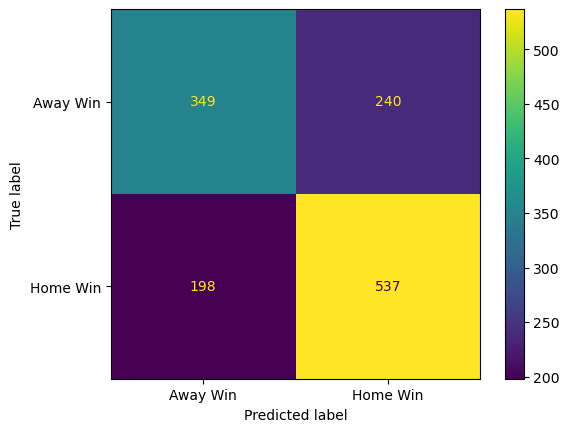

array([[-3.1953723 ,  1.21902682, -2.36427971, ..., -0.89613895,
         0.42763533, -1.94311064],
       [ 0.71842584, -0.87717771,  0.90376566, ..., -3.38126807,
        -0.29617234,  0.33836702],
       [ 0.31610737,  0.65788328, -0.17052182, ..., -2.7886747 ,
         0.75688487,  0.70806431],
       ...,
       [-0.30922958,  3.19021913, -2.22917801, ..., -1.28755597,
        -2.41308505, -2.64263047],
       [ 2.91156952, -1.96075787,  2.80433327, ...,  1.66901416,
        -2.77400572,  2.66315008],
       [-0.5823139 ,  0.64231723, -0.70108332, ..., -0.91563971,
        -1.12608153, -1.28151583]])

In [97]:
# Current best
# def getX(gameStats, filters):
#     return gameStats[filters]
print("Testing Accuracy  ", max_acc)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(maxy_test, maxy_pred), display_labels = ["Away Win", "Home Win"])
cm_display.plot()
plt.show()
x_train

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300, 500, 700, 1000],
    'num_parallel_tree': [1, 3, 5, 10, 50, 100],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.5, 1],
    'reg_alpha': [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1],
    'reg_lambda': [1, 2, 5, 7, 10, 15, 20]
}
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='logloss'),
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)
random_search.fit(x_train, y_train)
for i, score in enumerate(random_search.cv_results_['mean_test_score']):
    print(f"Iteration {i+1}: Accuracy = {score:.4f}, Params = {random_search.cv_results_['params'][i]}")
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Iteration 1: Accuracy = 0.5870, Params = {'subsample': 0.5, 'reg_lambda': 15, 'reg_alpha': 0.1, 'num_parallel_tree': 5, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 15, 'learning_rate': 0.001, 'gamma': 0, 'colsample_bytree': 0.5}
Iteration 2: Accuracy = 0.6119, Params = {'subsample': 1.0, 'reg_lambda': 20, 'reg_alpha': 0.5, 'num_parallel_tree': 3, 'n_estimators': 500, 'min_child_weight': 6, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 1.0}
Iteration 3: Accuracy = 0.6180, Params = {'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.1, 'num_parallel_tree': 5, 'n_estimators': 200, 'min_child_weight': 8, 'max_depth': 7, 'learning_rate': 0.005, 'gamma': 0.5, 'colsample_bytree': 1.0}
Iteration 4: Accuracy = 0.6216, Params = {'subsample': 0.5, 'reg_lambda': 20, 'reg_alpha': 0.05, 'num_parallel_tree': 3, 'n_estimators': 500, 'min_child_weight': 8, 'max_depth': 10, 'learning_rate': 0.01, 'gamma'

In [ ]:
random_search.cv_results_

{'mean_fit_time': array([25.80524667, 67.76076428, 48.18712926, 22.48877152, 84.92110602,
        42.72163955,  4.66580772,  0.33817856,  5.8127141 ,  3.19515117]),
 'std_fit_time': array([0.0994668 , 0.46629018, 0.20164189, 0.19886853, 0.54442881,
        5.60039294, 0.71160798, 0.0374231 , 0.23581784, 0.24592442]),
 'mean_score_time': array([0.26540017, 0.64718032, 0.46591719, 0.24497032, 0.70346109,
        0.21077013, 0.05473789, 0.00838717, 0.08798575, 0.02881106]),
 'std_score_time': array([0.01437178, 0.0174121 , 0.020618  , 0.02043043, 0.0156811 ,
        0.03754684, 0.00510744, 0.00332129, 0.02767781, 0.00815863]),
 'param_subsample': masked_array(data=[0.9, 0.9, 0.7, 0.9, 0.8, 1.0, 0.6, 1.0, 0.6, 1.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_reg_lambda': masked_array(data=[5, 7, 10, 1, 5, 7, 7, 20, 2, 5],
              mask=[False, False, False, F

In [17]:
def getTeam(team, stats):
    return stats.loc[stats["team"] == team]

def getGameSet(awayTeam, homeTeam):
    awayTeam = awayTeam.drop(["team"], axis=1)
    homeTeam = homeTeam.drop(["team"], axis=1)
    diff = pd.DataFrame(np.subtract(homeTeam.values, awayTeam.values), columns=homeTeam.columns)
    return diff

In [82]:
away = getTeam("Anaheim Ducks", teamdata25)
home = getTeam("Montreal Canadiens", teamdata25)
gameSet = getGameSet(away, home)
prediction = getX(gameSet, filter_xgboost)
result = model.predict(prediction.values)
result = (result >= 0.5).astype(int)
print(result)
prediction

[1]


,GS,GA,GD,Win%,xGoalsPercentage,corsiPercentage,fenwickPercentage,shotAttemptsFor,shotAttemptsAgainst,xReboundsFor,xReboundsAgainst,xOnGoalFor,xOnGoalAgainst,xGoalsFor,xGoalsAgainst,shotsOnGoalFor,shotsOnGoalAgainst,blockedShotAttemptsFor,xGoalsFromxReboundsOfShotsFor,unblockedShotAttemptsAgainst,blockedShotAttemptsAgainst,takeawaysFor,takeawaysAgainst,penaltiesFor,faceOffsWonFor
0,0.443929,0.639422,-0.142552,0.053172,0.052942,0.052662,0.052662,-1.511007,-0.505611,-0.052904,-0.027211,-1.951426,-0.975913,0.020546,0.020825,-1.064164,-0.449756,0.862843,0.030599,-1.622717,1.170048,0.611495,0.30429,0.862843,3.124983


In [98]:
import pickle
# file_name = "xgb66.pkl"
# pickle.dump(model, open(file_name, "wb"))

In [11]:
file_name = "xgb.pkl"
test = pickle.load(open(file_name,"rb"))

In [14]:
away = getTeam("Utah Hockey Club", teamdata25)
home = getTeam("San Jose Sharks", teamdata25)
gameSet = getGameSet(away, home)
prediction = getX(gameSet, filter_xgboost)
result = test.predict(prediction.values)
result = (result >= 0.5).astype(int)
print(result)
prediction.columns = [f"{i}: {col}" for i, col in enumerate(prediction.columns)]
prediction

[0]


,0: GS,1: GA,2: GD,3: Win%,4: xGoalsPercentage,5: corsiPercentage,6: fenwickPercentage,7: shotAttemptsFor,8: shotAttemptsAgainst,9: xReboundsFor,10: xReboundsAgainst,11: xOnGoalFor,12: xOnGoalAgainst,13: xGoalsFor,14: xGoalsAgainst,15: shotsOnGoalFor,16: shotsOnGoalAgainst,17: blockedShotAttemptsFor,18: xGoalsFromxReboundsOfShotsFor,19: unblockedShotAttemptsAgainst,20: blockedShotAttemptsAgainst,21: takeawaysFor,22: takeawaysAgainst,23: penaltiesFor,24: faceOffsWonFor
0,-0.55351,-0.311018,-0.796001,-0.554587,-0.553833,-0.553914,-0.553995,0.036553,3.310186,-0.507679,-0.395001,-0.324517,1.406063,-0.52821,-0.398154,0.19013,1.257092,-0.270603,-0.538637,2.34022,0.416456,-0.513094,-0.73942,-0.55351,-0.311018


In [40]:
# aways = ["Ottawa Senators","Chicago Blackhawks","Los Angeles Kings","Philadelphia Flyers","Vegas Golden Knights","Anaheim Ducks","Buffalo Sabres","Montreal Canadiens","Pittsburgh Penguins","Toronto Maple Leafs","St. Louis Blues","Nashville Predators","Boston Bruins","Florida Panthers","Tampa Bay Lightning","Utah Hockey Club"]
# homes = ["Carolina Hurricanes","New Jersey Devils","New York Rangers","Minnesota Wild","Edmonton Oilers","Columbus Blue Jackets","Washington Capitals","Winnipeg Jets","Ottawa Senators","Detroit Red Wings","Dallas Stars","Colorado Avalanche","Vancouver Canucks","Calgary Flames","Seattle Kraken","San Jose Sharks"]
aways = ["New York Islanders", "Buffalo Sabres", "Columbus Blue Jackets", "New York Rangers", "Vegas Golden Knights"]
homes = ["Chicago Blackhawks", "Toronto Maple Leafs", "Carolina Hurricanes", "St. Louis Blues", "Minnesota Wild"]
p = []
year = teamdata25
for i in range(len(aways)):
    print(i)
    a = getTeam(aways[i], year)
    h = getTeam(homes[i], year)
    gS = getGameSet(a,h)
    t = getX(gS, filter_xgboost)
    cols_to_move = ["Away", "Home", "Prediction"]
    t["Away"] = aways[i]
    t["Home"] = homes[i]
    t["Prediction"] = -1
    t = t[cols_to_move + [col for col in t.columns if col not in cols_to_move]]
    p.append(t)

predictions = pd.concat(p, ignore_index=True)
results = test.predict(predictions[filter_xgboost].values)
predictions["Prediction"] = results
print(results)
predictions

0
1
2
3
4
[0 1 1 0 1]


,Away,Home,Prediction,GS,GA,GD,Win%,xGoalsPercentage,corsiPercentage,fenwickPercentage,shotAttemptsFor,shotAttemptsAgainst,xReboundsFor,xReboundsAgainst,xOnGoalFor,xOnGoalAgainst,xGoalsFor,xGoalsAgainst,shotsOnGoalFor,shotsOnGoalAgainst,blockedShotAttemptsFor,xGoalsFromxReboundsOfShotsFor,unblockedShotAttemptsAgainst,blockedShotAttemptsAgainst,takeawaysFor,takeawaysAgainst,penaltiesFor,faceOffsWonFor
0,New York Islanders,Chicago Blackhawks,0,0.269874,0.437696,0.241903,0.408508,0.409027,0.409166,0.409166,-2.611079,0.675445,0.261063,0.438116,-1.537575,0.315605,0.177012,0.429585,-0.946839,0.451681,0.088066,0.375882,0.367770,0.717400,0.787326,0.088066,0.633489,-3.296354
1,Buffalo Sabres,Toronto Maple Leafs,1,0.017400,-0.426803,0.508362,0.069614,0.064860,0.063223,0.063925,-2.834852,2.472208,0.059950,0.043117,-0.627396,-0.061154,0.190873,-0.104405,0.484983,-0.052737,-1.736034,0.063925,0.064159,2.472208,-0.169633,0.181054,-0.099495,-0.707352
2,Columbus Blue Jackets,Carolina Hurricanes,1,0.252829,0.036401,0.434628,0.220111,0.218806,0.218893,0.218806,1.776478,-3.305239,0.285379,0.145913,1.144683,-1.157673,0.389178,0.142104,0.278800,-0.907223,0.521199,0.235341,-1.842190,-1.244850,0.555827,0.278800,0.114315,0.988682
3,New York Rangers,St. Louis Blues,0,-0.043732,0.397700,-0.251465,0.188263,0.188929,0.189448,0.189188,-1.913329,1.799897,-0.049185,0.129205,-2.512638,-0.175383,-0.211477,0.128167,-1.653663,-0.121632,1.773931,0.132841,0.215934,1.773931,-0.043732,0.917032,0.112067,-1.160297
4,Vegas Golden Knights,Minnesota Wild,1,0.359390,0.208783,0.848866,0.699513,0.698635,0.698635,0.698635,-0.205389,-2.276247,0.606387,0.559699,-0.025413,-1.179822,0.335293,0.157199,-0.996080,0.924170,0.246435,0.680938,-1.485555,-0.092433,-0.092433,-0.167737,1.564253,-2.765722


0.667107250755287


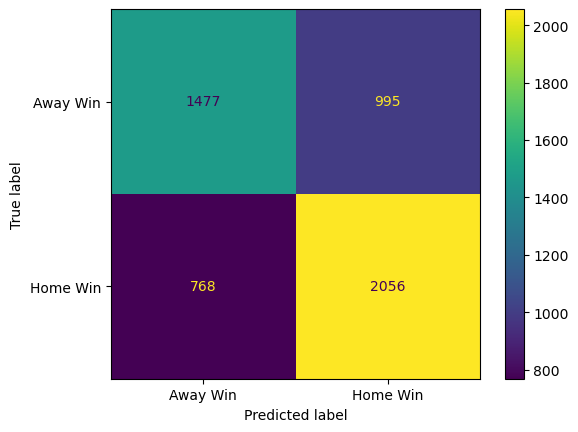

In [95]:
x = getX(all_game_stats, filter_xgboost)
y = getY(all_game_stats)
prediction = test.predict(x)
print(accuracy_score(y,prediction))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y,prediction), display_labels = ["Away Win", "Home Win"])
cm_display.plot()
plt.show()

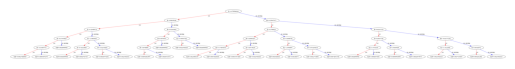

In [46]:
import graphviz

from xgboost import plot_tree
plot_tree(test)
plt.savefig('tree_plot.png', dpi=3000, bbox_inches='tight')  # High-resolution file